# Lenia [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/maxencefaldor/cax/blob/main/examples/20_lenia.ipynb)

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX with:

In [ ]:
%pip install -U "jax[cuda12]"

Then, install CAX from PyPi:

In [ ]:
%pip install -U "cax[examples]"

## Import

In [1]:
import pickle

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import mediapy
from cax.models.lenia import (
	FreeKernelParams,
	GrowthParams,
	Lenia,
	OriginalKernelParams,
	RuleParams,
	free_kernel_fn,
	growth_exponential,
	original_kernel_fn,
)
from flax import nnx

## Configuration

In [2]:
seed = 0

num_dims = 2
state_size = 128
channel_size = 3

R = 12
T = 2

state_scale = 2

key = jax.random.key(seed)
rngs = nnx.Rngs(seed)

## Init state

In [3]:
def init_state(pattern):
	pattern = jnp.transpose(pattern, axes=(1, 2, 0))

	mid = state_size // 2

	# Scale cells
	scaled_cells = pattern.repeat(state_scale, axis=-3).repeat(state_scale, axis=-2)
	cx, cy = scaled_cells.shape[0], scaled_cells.shape[1]

	# Create empty state and place cells
	state = jnp.zeros((state_size, state_size, channel_size))
	state = state.at[mid - cx // 2 : mid + cx - cx // 2, mid - cy // 2 : mid + cy - cy // 2, :].set(
		scaled_cells
	)
	return state

## Model

This section demonstrates how to visualize well-known Lenia creatures by loading rule parameters and patterns from `cax/models/lenia/assets`.

You can run either the VT049W or 5N7KKM section below. You can also experiment with combining rule parameters from one soliton with the pattern of another to observe novel emergent behaviors.

### VT049W

In [4]:
# Load rule params for soliton VT049W
with open("../cax/models/lenia/assets/VT049W/rule_params.pickle", "rb") as f:
	rule_params = pickle.load(f)

In [5]:
# Load pattern for soliton VT049W
with open("../cax/models/lenia/assets/VT049W/Aquarium.pickle", "rb") as f:
	pattern = pickle.load(f)

### 5N7KKM

In [6]:
# Rule params
with open("../cax/models/lenia/assets/5N7KKM/rule_params.pickle", "rb") as f:
	rule_params = pickle.load(f)

In [7]:
# Pattern
with open("../cax/models/lenia/assets/5N7KKM/Aquarium_swarm.pickle", "rb") as f:
	pattern = pickle.load(f)

In [8]:
ca = Lenia(
	num_dims=num_dims,
	channel_size=channel_size,
	R=R,
	T=T,
	rule_params=rule_params,
	state_size=state_size,
	state_scale=state_scale,
)

## Visualize

In [9]:
state = init_state(pattern)
states = ca(state, num_steps=256, all_steps=True)

""

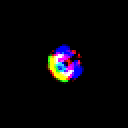

In [10]:
states = jnp.concatenate([state[None], states])
mediapy.show_video(states, width=256, height=256, codec="gif")

## Rule Parameters

In this section, we will deep dive into what are the rule parameters in Lenia and explore the `RuleParams` object provided by CAX, how it works, and how you can define your own rule parameters to experiment with new Lenia worlds.

In Lenia, the state is a $d$-dimensional lattice $A^{t}$ with $c$ channels that evolves from $A^t$ to $A^{t+dt}$ based on a set of rules. Each rule consists of a source channel, a target channel, a weight, a kernel and a growth mapping function, see "Lenia and Expanded Universe", Bert Wang-Chak Chan, (2020) for more details.

In CAX, the parameters of a rule are defined through the `RuleParams` object. For example:

In [11]:
rule_params = RuleParams(
	channel_source=0,
	channel_target=1,
	weight=1.0,
	kernel_params=OriginalKernelParams(
		r=0.82,
		b=jnp.array([1 / 6, 1.0, 0.2]),
	),
	growth_params=GrowthParams(
		mean=0.0,
		std=0.05,
	),
)

We will now explore how to define custom kernels and growth mapping functions.

### Kernels

This section explores the kernel functions available in Lenia through CAX. We"ll examine the built-in kernel functions and demonstrate how to create custom kernels for your own experiments.

#### Original kernel function

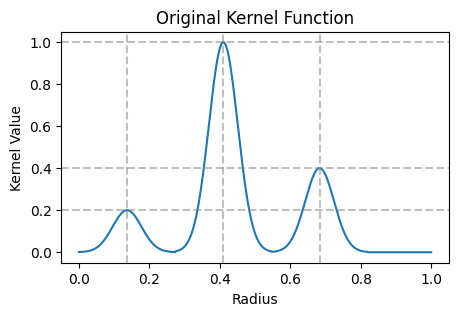

In [9]:
kernel_params = OriginalKernelParams(
	r=0.82,
	b=jnp.array([0.2, 1.0, 0.4]),
)

# Plot the original kernel function
r = jnp.linspace(0.0, 1.0, 1000)
kernel_values = original_kernel_fn(r, kernel_params)

plt.figure(figsize=(5, 3))
plt.plot(r, kernel_values)

# Add horizontal lines for b values
for b in kernel_params.b:
	plt.axhline(y=b, color="gray", linestyle="--", alpha=0.5)

# Add vertical lines at peaks (segment boundaries)
number_of_segments = jnp.count_nonzero(~jnp.isnan(kernel_params.b), axis=-1)
for i in range(number_of_segments):
	peak_x = (i + 0.5) * kernel_params.r / number_of_segments
	plt.axvline(x=peak_x, color="gray", linestyle="--", alpha=0.5)

plt.xlabel("Radius")
plt.ylabel("Kernel Value")
plt.title("Original Kernel Function")
plt.show()

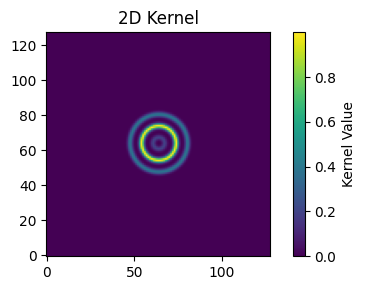

In [13]:
# Visualize the kernel as a 2D heatmap
import numpy as np

# Create a 2D grid for the kernel
mid = state_size // 2
x = np.mgrid[slice(-mid, mid), slice(-mid, mid)] / (state_scale * R)
d = np.linalg.norm(x, axis=0)

# Apply the kernel function to the distances
kernel_2d = original_kernel_fn(jnp.array(d), kernel_params)

# Plot the 2D kernel
plt.figure(figsize=(5, 3))
plt.imshow(kernel_2d, origin="lower")

plt.title("2D Kernel")
plt.colorbar(label="Kernel Value")

plt.tight_layout()
plt.show()

#### Free kernel function

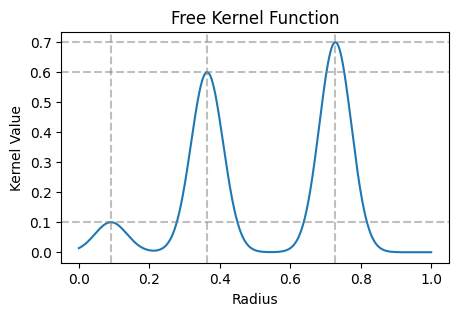

In [50]:
kernel_params = FreeKernelParams(
	r=0.91,
	b=jnp.array([0.1, 0.6, 0.7]),
	a=jnp.array([0.1, 0.4, 0.8]),
	w=jnp.array([0.05, 0.05, 0.05]),
)

# Plot the free kernel function
r = jnp.linspace(0.0, 1.0, 1000)
kernel_values = jax.vmap(free_kernel_fn, in_axes=(0, None))(r, kernel_params)

plt.figure(figsize=(5, 3))
plt.plot(r, kernel_values)

# Add horizontal lines for b values
for b in kernel_params.b:
	plt.axhline(y=b, color="gray", linestyle="--", alpha=0.5)

# Add vertical lines at peak positions
for a in kernel_params.a:
	plt.axvline(x=a * kernel_params.r, color="gray", linestyle="--", alpha=0.5)

plt.xlabel("Radius")
plt.ylabel("Kernel Value")
plt.title("Free Kernel Function")
plt.show()

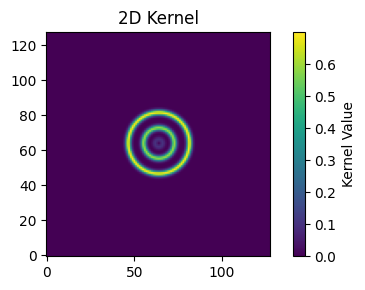

In [15]:
# Visualize the kernel as a 2D heatmap
import numpy as np

# Create a 2D grid for the kernel
mid = state_size // 2
x = np.mgrid[slice(-mid, mid), slice(-mid, mid)] / (state_scale * R)
d = np.linalg.norm(x, axis=0)

# Apply the kernel function to the distances
kernel_2d = free_kernel_fn(jnp.array(d), kernel_params)

# Plot the 2D kernel
plt.figure(figsize=(5, 3))
plt.imshow(kernel_2d, origin="lower")

plt.title("2D Kernel")
plt.colorbar(label="Kernel Value")

plt.tight_layout()
plt.show()

### Growth Mapping Function

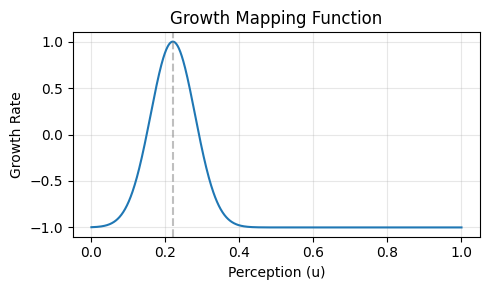

In [ ]:
growth_params = GrowthParams(
	mean=0.22,
	std=0.06,
)

# Plot the growth mapping function
u_values = jnp.linspace(0, 1, 1000)
growth_values = growth_exponential(u_values, growth_params)

plt.figure(figsize=(5, 3))
plt.plot(u_values, growth_values)

# Add vertical line at the mean
plt.axvline(x=growth_params.mean, color="gray", linestyle="--", alpha=0.5)

plt.xlabel("Perception (u)")
plt.ylabel("Growth Rate")

plt.title("Growth Mapping Function")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Orbium - Putting it Together

In [11]:
num_dims = 2
state_size = 128
channel_size = 1

R = 12
T = 10

state_scale = 2

#### Kernel

In [12]:
kernel_params = OriginalKernelParams(
	r=jnp.array(1.0, jnp.float32),
	b=jnp.array([1.0]),
)

#### Growth Mapping Function

In [13]:
growth_params = GrowthParams(
	mean=jnp.array(0.15, jnp.float32),
	std=jnp.array(0.015, jnp.float32),
)

#### Rule Params

In [14]:
rule_params = RuleParams(
	channel_source=jnp.array(0, jnp.int32),
	channel_target=jnp.array(0, jnp.int32),
	weight=jnp.array(1.0, jnp.float32),
	kernel_params=kernel_params,
	growth_params=growth_params,
)
rule_params = jax.tree.map(lambda x: x[None], rule_params)

#### Model

In [15]:
ca = Lenia(
	num_dims=num_dims,
	channel_size=channel_size,
	R=R,
	T=T,
	state_size=state_size,
	state_scale=state_scale,
	rule_params=rule_params,
)

#### Visualize

In [16]:
# fmt: off
orbium = jnp.array(
	[
		[
		[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.14, 0.1, 0.0, 0.0, 0.03, 0.03, 0.0, 0.0, 0.3, 0.0, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.0, 0.08, 0.24, 0.3, 0.3, 0.18, 0.14, 0.15, 0.16, 0.15, 0.09, 0.2, 0.0, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.0, 0.15, 0.34, 0.44, 0.46, 0.38, 0.18, 0.14, 0.11, 0.13, 0.19, 0.18, 0.45, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.06, 0.13, 0.39, 0.5, 0.5, 0.37, 0.06, 0.0, 0.0, 0.0, 0.02, 0.16, 0.68, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.11, 0.17, 0.17, 0.33, 0.4, 0.38, 0.28, 0.14, 0.0, 0.0, 0.0, 0.0, 0.0, 0.18, 0.42, 0.0, 0.0],
		[0.0, 0.0, 0.09, 0.18, 0.13, 0.06, 0.08, 0.26, 0.32, 0.32, 0.27, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.82, 0.0, 0.0],
		[0.27, 0.0, 0.16, 0.12, 0.0, 0.0, 0.0, 0.25, 0.38, 0.44, 0.45, 0.34, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22, 0.17, 0.0],
		[0.0, 0.07, 0.2, 0.02, 0.0, 0.0, 0.0, 0.31, 0.48, 0.57, 0.6, 0.57, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.49, 0.0],
		[0.0, 0.59, 0.19, 0.0, 0.0, 0.0, 0.0, 0.2, 0.57, 0.69, 0.76, 0.76, 0.49, 0.0, 0.0, 0.0, 0.0, 0.0, 0.36, 0.0],
		[0.0, 0.58, 0.19, 0.0, 0.0, 0.0, 0.0, 0.0, 0.67, 0.83, 0.9, 0.92, 0.87, 0.12, 0.0, 0.0, 0.0, 0.0, 0.22, 0.07],
		[0.0, 0.0, 0.46, 0.0, 0.0, 0.0, 0.0, 0.0, 0.7, 0.93, 1.0, 1.0, 1.0, 0.61, 0.0, 0.0, 0.0, 0.0, 0.18, 0.11],
		[0.0, 0.0, 0.82, 0.0, 0.0, 0.0, 0.0, 0.0, 0.47, 1.0, 1.0, 0.98, 1.0, 0.96, 0.27, 0.0, 0.0, 0.0, 0.19, 0.1],
		[0.0, 0.0, 0.46, 0.0, 0.0, 0.0, 0.0, 0.0, 0.25, 1.0, 1.0, 0.84, 0.92, 0.97, 0.54, 0.14, 0.04, 0.1, 0.21, 0.05],
		[0.0, 0.0, 0.0, 0.4, 0.0, 0.0, 0.0, 0.0, 0.09, 0.8, 1.0, 0.82, 0.8, 0.85, 0.63, 0.31, 0.18, 0.19, 0.2, 0.01],
		[0.0, 0.0, 0.0, 0.36, 0.1, 0.0, 0.0, 0.0, 0.05, 0.54, 0.86, 0.79, 0.74, 0.72, 0.6, 0.39, 0.28, 0.24, 0.13, 0.0],
		[0.0, 0.0, 0.0, 0.01, 0.3, 0.07, 0.0, 0.0, 0.08, 0.36, 0.64, 0.7, 0.64, 0.6, 0.51, 0.39, 0.29, 0.19, 0.04, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.1, 0.24, 0.14, 0.1, 0.15, 0.29, 0.45, 0.53, 0.52, 0.46, 0.4, 0.31, 0.21, 0.08, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.0, 0.08, 0.21, 0.21, 0.22, 0.29, 0.36, 0.39, 0.37, 0.33, 0.26, 0.18, 0.09, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.03, 0.13, 0.19, 0.22, 0.24, 0.24, 0.23, 0.18, 0.13, 0.05, 0.0, 0.0, 0.0, 0.0],
		[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.06, 0.08, 0.09, 0.07, 0.05, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0]
		]
	]
)

In [17]:
state = init_state(orbium)
states = ca(state, num_steps=256, all_steps=True)

""

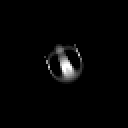

In [18]:
states = jnp.concatenate([state[None], states])
mediapy.show_video(states[..., 0], width=256, height=256, codec="gif")

## Sampling Rules

### Configuration

In [9]:
num_dims = 2
state_size = 128
channel_size = 3

R = 12
T = 2

state_scale = 2

### Define sampling distribution

In [10]:
def sample_kernel_params(key: jax.Array, k=3):
	"""Sample kernel parameters according to a specific distribution."""
	key_r, key_b, key_segments = jax.random.split(key, 3)
	r = jax.random.uniform(key_r, minval=0.2, maxval=1.0)

	# Create mask for active segments
	mask = jnp.cumsum(
		jax.nn.one_hot(jax.random.randint(key_segments, (), minval=1, maxval=k + 1), k)
	)

	# Create b array with shape (k,)
	b = jax.random.uniform(key_b, (k,), minval=0.1, maxval=1.0)

	# Fill the inactive segments with nans
	b = jnp.where(mask, jnp.nan, b)

	return OriginalKernelParams(r=r, b=b)


def sample_growth_params(key: jax.Array):
	"""Sample growth parameters according to a specific distribution."""
	key_mean, key_std = jax.random.split(key)
	mean = jax.random.uniform(key_mean, minval=0.05, maxval=0.5)
	std = jax.random.uniform(key_std, minval=0.001, maxval=0.18)
	return GrowthParams(mean=mean, std=std)


def sample_rule_params(key: jax.Array, k: int = 3):
	"""Sample rule parameters according to a specific distribution."""
	key_channel_source, key_channel_target, key_weight, key_kernel_params, key_growth_params = (
		jax.random.split(key, 5)
	)

	# Sample channel source and target
	channel_source = jax.random.randint(key_channel_source, (), minval=0, maxval=channel_size)
	channel_target = jax.random.randint(key_channel_target, (), minval=0, maxval=channel_size)

	# Sample weight
	weight = jax.random.uniform(key_weight, minval=0.01, maxval=1.0)

	# Sample kernel and growth parameters
	kernel_params = sample_kernel_params(key_kernel_params, k)
	growth_params = sample_growth_params(key_growth_params)

	return RuleParams(
		channel_source=channel_source,
		channel_target=channel_target,
		weight=weight,
		kernel_params=kernel_params,
		growth_params=growth_params,
	)

In [11]:
seed = 0

key = jax.random.key(seed)
keys = jax.random.split(key, 15)
rule_params = jax.vmap(sample_rule_params)(keys)

### Instantiate Lenia with sampled rules

In [12]:
ca = Lenia(
	num_dims=num_dims,
	channel_size=channel_size,
	R=R,
	T=T,
	state_size=state_size,
	state_scale=state_scale,
	rule_params=rule_params,
)

### Sample rules

In [108]:
seed = 1

key = jax.random.key(seed)
keys = jax.random.split(key, 15)
rule_params = jax.vmap(sample_rule_params)(keys)

In [109]:
ca.update_rule_params(rule_params)

### Visualize

In [86]:
state = init_state(pattern)
states = ca(state, num_steps=256, all_steps=True)

Uniformly sampled Lenia rule parameters often result in patterns that either vanish or explode. For a more stable approach, see [examples/21_flow_lenia.ipynb](../examples/21_flow_lenia.ipynb).

""

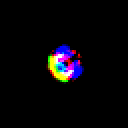

In [87]:
states = jnp.concatenate([state[None], states])
mediapy.show_video(states, width=256, height=256, codec="gif")